In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from helpings import *
from utils import*

In [ ]:
#########################################
# Data Loading
#########################################

image_dir = "/Users/aurelien/ML/ML_course-main/projects/project2/data/training/augmented/images"
mask_dir = "/Users/aurelien/ML/ML_course-main/projects/project2/data/training/augmented/groundtruth"

image_files = sorted(glob.glob(os.path.join(image_dir, "*.png")))
mask_files = sorted(glob.glob(os.path.join(mask_dir, "*.png")))

# Load all images into memory
images = [plt.imread(f) for f in image_files]  # shape ~ (256,256,3)
masks = [plt.imread(fm) for fm in mask_files]  # shape ~ (256,256), binary mask

# Stack into arrays
images = np.stack(images, axis=0)
masks = np.stack(masks, axis=0)

# Ensure images are normalized
if images.max() > 1.0:  # Pixel values likely in [0, 255]
    print("Images are not normalized. Normalizing to [0, 1].")
    images = images / 255.0
else:
    print("Images are already normalized.")

# Ensure masks are binary 0/1
masks = (masks > 0.5).astype(np.float32)

# Print shapes for verification
print("Images shape:", images.shape)
print("Masks shape:", masks.shape)

Images are already normalized.
Images shape: (600, 400, 400, 3)
Masks shape: (600, 400, 400)
Image pixel range: 0.0 - 1.0
Mask pixel range: 0.0 - 1.0


In [13]:
#########################################
# Train/Val/Test Split
#########################################
trainval_images, test_images, trainval_masks, test_masks = train_test_split(
    images, masks, test_size=0.1, random_state=42
)
train_images, val_images, train_masks, val_masks = train_test_split(
    trainval_images, trainval_masks, test_size=0.2, random_state=42
)

print("Train Images Shape:", train_images.shape)
print("Train Masks Shape:", train_masks.shape)
print("Validation Images Shape:", val_images.shape)
print("Validation Masks Shape:", val_masks.shape)

Train Images Shape: (432, 400, 400, 3)
Train Masks Shape: (432, 400, 400)
Validation Images Shape: (108, 400, 400, 3)
Validation Masks Shape: (108, 400, 400)


In [ ]:
#########################################
# Hyperparameters
#########################################
input_shape = train_images.shape[1:]  # Dynamically get input shape
lr = 1e-4
patience = 5


batch = 16
n_layers = 4
epochs = 100
init_filters = 16
reg = 1e-6
d_out=0.1

model_400B16F16RD = build_unet(input_shape=input_shape,num_layers=n_layers,initial_filters=init_filters,dropout_rate=d_out,l2_reg=reg)

# Compile the model
model_400B16F16RD.compile(optimizer=Adam(learning_rate=lr), 
              loss=combined_loss,
              metrics=["accuracy"])

# Summary
model_400B16F16RD.summary()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "model_400B16F16RD.h5", save_best_only=True, monitor="val_loss", mode="min"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=patience, restore_best_weights=True, monitor="val_loss", mode="min"
)

history_400B16F16RD = model_400B16F16RD.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=epochs,
    batch_size=batch,
    callbacks=[checkpoint_cb, earlystop_cb]
)

model_400B16F16RD.save("model_400B16F16RD.h5")

Model: "U-Net_400x400"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 conv2d_30 (Conv2D)          (None, 400, 400, 16)         448       ['input_3[0][0]']             
                                                                                                  
 conv2d_31 (Conv2D)          (None, 400, 400, 16)         2320      ['conv2d_30[0][0]']           
                                                                                                  
 dropout_14 (Dropout)        (None, 400, 400, 16)         0         ['conv2d_31[0][0]']           
                                                                                      

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 105s 4s/step - loss: 0.7932 - accuracy: 0.7956 - val_loss: 0.7674 - val_accuracy: 0.8189
Epoch 3/100
27/27 [==============================] - 105s 4s/step - loss: 0.7595 - accuracy: 0.7936 - val_loss: 0.7582 - val_accuracy: 0.7671
Epoch 4/100
27/27 [==============================] - 107s 4s/step - loss: 0.7293 - accuracy: 0.7888 - val_loss: 0.7416 - val_accuracy: 0.6882
Epoch 5/100
27/27 [==============================] - 106s 4s/step - loss: 0.6915 - accuracy: 0.7983 - val_loss: 0.6832 - val_accuracy: 0.7850
Epoch 6/100
27/27 [==============================] - 107s 4s/step - loss: 0.6596 - accuracy: 0.8086 - val_loss: 0.6783 - val_accuracy: 0.7457
Epoch 7/100
27/27 [==============================] - 107s 4s/step - loss: 0.6084 - accuracy: 0.8324 - val_loss: 0.6500 - val_accuracy: 0.7688
Epoch 8/100
27/27 [==============================] - 106s 4s/step - loss: 0.5713 - accuracy: 0.8485 - val_loss: 0.6197 - val_accuracy: 0.7981
Epoch 9/100
27/27 

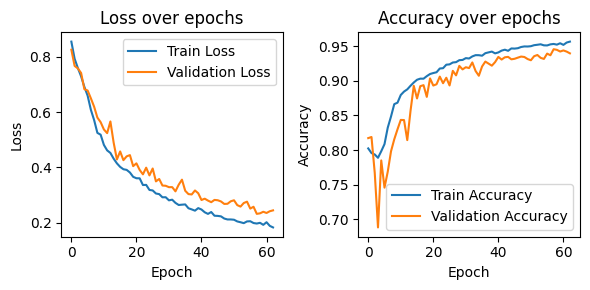

In [ ]:
plot_training_history(history_400B16F16RD)

In [ ]:
optimal_threshold_400B16F16RD, f1_scores_400B16F16RD = find_optimal_threshold(model_400B16F16RD, val_images, val_masks,thresholds=np.arange(0.1, 0.91, 0.02))

4/4 [==============================] - 7s 2s/step


In [41]:
print(optimal_threshold_400B16F16RD)

0.44000000000000006


1/1 [==============================] - 0s 104ms/step
F1-score model 400B16F16RD : 0.6651836037635803


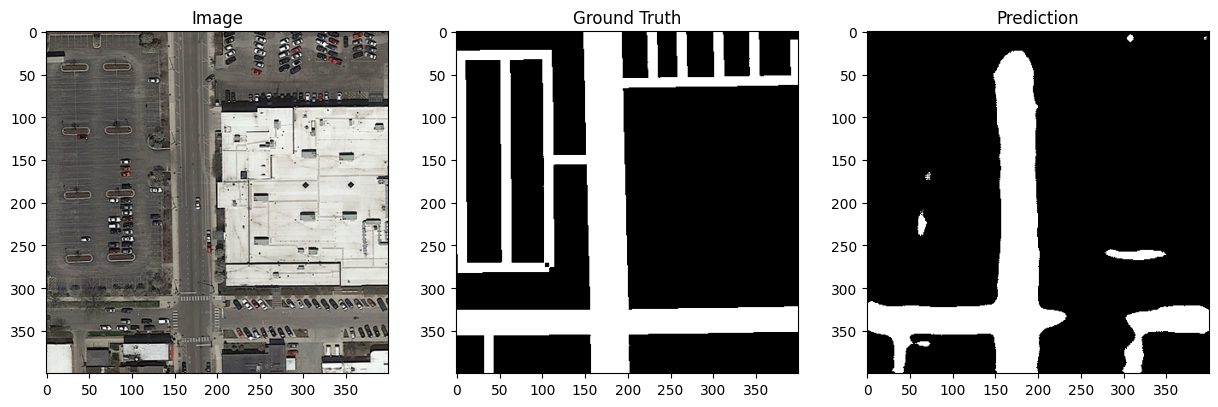

In [74]:
new_image = test_images[4]  
new_mask = test_masks[4]    

pred_binarized = predict_on_image(model_400B16F16RD, new_image, optimal_threshold_400B16F16RD)

f1 = calculate_f1_on_image(pred_binarized, new_mask)
print(f"F1-score model 400B16F16RD : {f1}")
visualize_prediction(new_image, new_mask, pred_binarized)

[0, 104, 208]


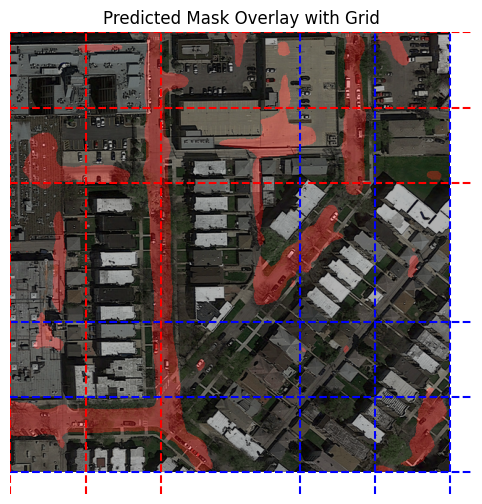

In [52]:
# Load a new 608x608x3 image
new_image = plt.imread("/Users/aurelien/ML/ML_course-main/projects/project2/data/test_set_images/test_4/test_4.png")[:608, :608, :]

# Make a prediction on the image
predicted_mask = predict_on_large_image(model_400B16F16RD, new_image, optimal_threshold_400B16F16RD, patch_size=400)

# Extract patches to get coordinates (for visualization only)
_, patch_coords = extract_patches_from_large_image(new_image, patch_size=400)

# Visualize the prediction overlay with grid
visualize_prediction_with_overlay(new_image, predicted_mask, patch_coords, patch_size=400)

In [53]:
print ("Model 400B16F16RD")
print("Train set")
average_f1_256B32F16 = calculate_f1_on_set(model_400B16F16RD, train_images, train_masks, threshold=optimal_threshold_400B16F16RD)
print("___________________________")
print("Val set")
average_f1_256B32F16 = calculate_f1_on_set(model_400B16F16RD, val_images, val_masks, threshold=optimal_threshold_400B16F16RD)
print("___________________________")
print("Test set")
average_f1_256B32F16 = calculate_f1_on_set(model_400B16F16RD, test_images, test_masks, threshold=optimal_threshold_400B16F16RD)
print("___________________________")

Model 400B16F16RD
Train set
Average F1-score on set: 0.8669
___________________________
Val set
Average F1-score on set: 0.8214
___________________________
Test set
Average F1-score on set: 0.7915
___________________________


In [ ]:
#########################################
# Hyperparameters
#########################################
input_shape = train_images.shape[1:]  # Dynamically get input shape
lr = 1e-4
patience = 10

batch = 16
n_layers = 4
epochs = 200
init_filters = 32
reg = 1e-6
d_out=0.1

model_400B16F32 = build_unet(input_shape=input_shape,num_layers=n_layers,initial_filters=init_filters,dropout_rate=d_out,l2_reg=reg)

# Compile the model
model_400B16F32.compile(optimizer=Adam(learning_rate=lr), 
              loss=combined_loss,
              metrics=["accuracy"])

# Summary
model_400B16F32.summary()

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "model_400B16F32.h5", save_best_only=True, monitor="val_loss", mode="min"
)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    patience=patience, restore_best_weights=True, monitor="val_loss", mode="min"
)

history_400B16F32 = model_400B16F32.fit(
    train_images, train_masks,
    validation_data=(val_images, val_masks),
    epochs=epochs,
    batch_size=batch,
    callbacks=[checkpoint_cb, earlystop_cb]
)
#Save the model
model_400B16F32.save("model_400B16F32.h5")

Model: "U-Net_400x400"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 400, 400, 3)]        0         []                            
                                                                                                  
 conv2d_49 (Conv2D)          (None, 400, 400, 32)         896       ['input_4[0][0]']             
                                                                                                  
 conv2d_50 (Conv2D)          (None, 400, 400, 32)         9248      ['conv2d_49[0][0]']           
                                                                                                  
 dropout_23 (Dropout)        (None, 400, 400, 32)         0         ['conv2d_50[0][0]']           
                                                                                      

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 336s 12s/step - loss: 0.8324 - accuracy: 0.7478 - val_loss: 0.8151 - val_accuracy: 0.8190
Epoch 2/200
27/27 [==============================] - 319s 12s/step - loss: 0.7729 - accuracy: 0.7851 - val_loss: 0.7738 - val_accuracy: 0.6796
Epoch 3/200
27/27 [==============================] - 319s 12s/step - loss: 0.7194 - accuracy: 0.7750 - val_loss: 0.7021 - val_accuracy: 0.7712
Epoch 4/200
27/27 [==============================] - 323s 12s/step - loss: 0.6681 - accuracy: 0.7992 - val_loss: 0.7003 - val_accuracy: 0.7594
Epoch 5/200
27/27 [==============================] - 321s 12s/step - loss: 0.6381 - accuracy: 0.8170 - val_loss: 0.6108 - val_accuracy: 0.8406
Epoch 6/200
27/27 [==============================] - 322s 12s/step - loss: 0.5628 - accuracy: 0.8497 - val_loss: 0.5425 - val_accuracy: 0.8768
Epoch 7/200
27/27 [==============================] - 312s 12s/step - loss: 0.4795 - accuracy: 0.8798 - val_loss: 0.5298 - val_accuracy: 0.8526
Epoch 8/200

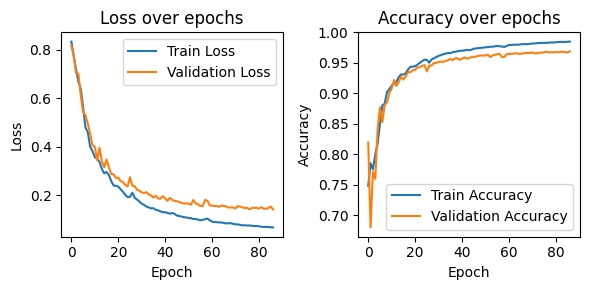

In [77]:
plot_training_history(history_400B16F32)

In [55]:
optimal_threshold_400B16F32, f1_scores_400B16F32 = find_optimal_threshold(model_400B16F32, val_images, val_masks,thresholds=np.arange(0.1, 0.91, 0.02))

4/4 [==============================] - 24s 5s/step


In [56]:
print(optimal_threshold_400B16F32)

0.3400000000000001


1/1 [==============================] - 0s 236ms/step
F1-score on the img 400B16F32 : 0.9108847379684448


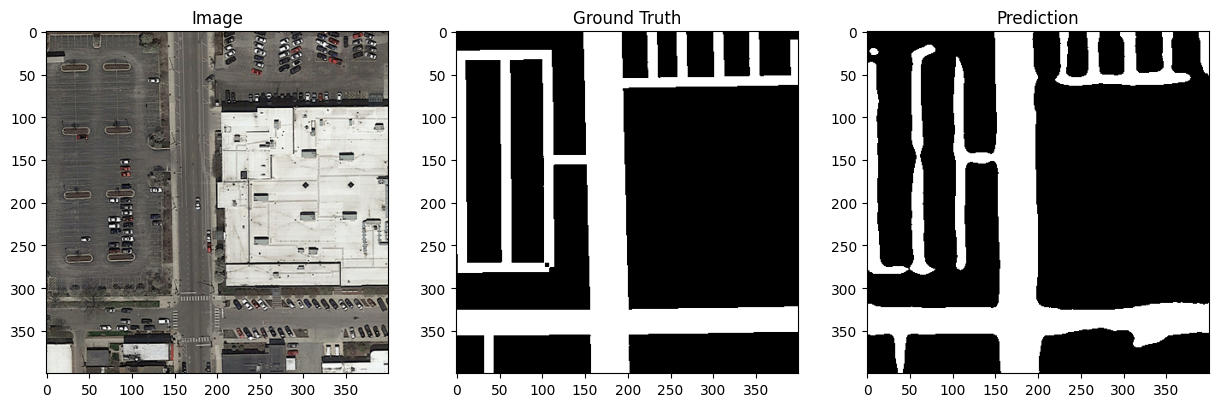

In [76]:
new_image = test_images[4]  
new_mask = test_masks[4]    

pred_binarized = predict_on_image(model_400B16F32, new_image, 0.34)

f1 = calculate_f1_on_image(pred_binarized, new_mask)
print(f"F1-score on the img 400B16F32 : {f1}")
visualize_prediction(new_image, new_mask, pred_binarized)

In [75]:
print ("Model 400B16F32")
print("Train set")
average_f1_256B32F32 = calculate_f1_on_set(model_400B16F32, train_images, train_masks, threshold=optimal_threshold_400B16F32)
print("___________________________")
print("Val set")
average_f1_256B32F32 = calculate_f1_on_set(model_400B16F32, val_images, val_masks, threshold=optimal_threshold_400B16F32)
print("___________________________")
print("Test set")
average_f1_256B32F32 = calculate_f1_on_set(model_400B16F32, test_images, test_masks, threshold=optimal_threshold_400B16F32)
print("___________________________")

Model 400B16F32
Train set
Average F1-score on set: 0.9572
___________________________
Val set
Average F1-score on set: 0.8956
___________________________
Test set
Average F1-score on set: 0.8757
___________________________
